In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
BATCH_COUNT = len(dataset)
BATCH_COUNT

68

In [7]:
(67 * 32) + 8

2152

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1]


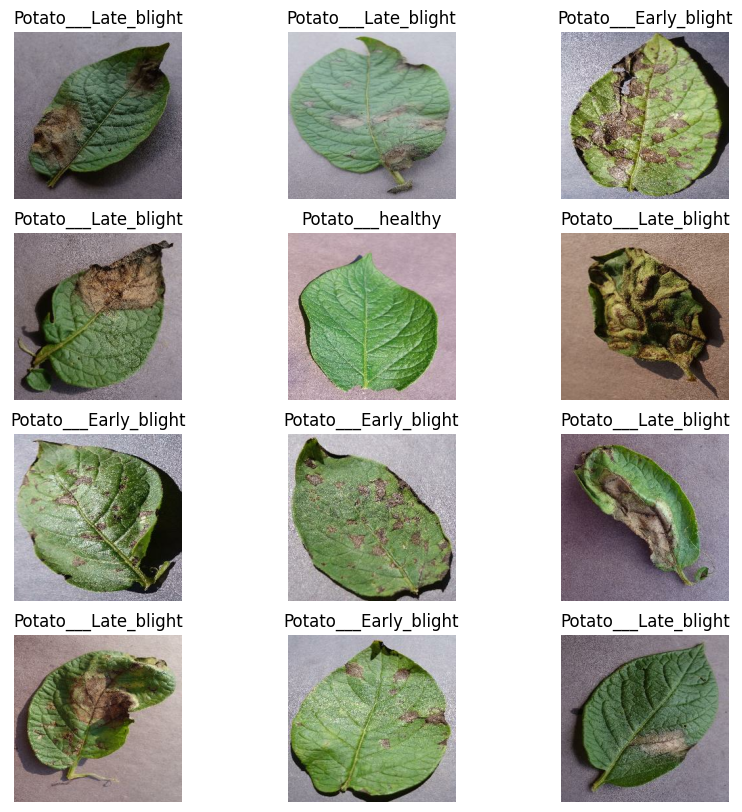

In [9]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
train_size = 0.8
val_size = 0.1

In [11]:
train_ds = dataset.take(int(BATCH_COUNT*train_size))
len(train_ds)

54

In [12]:
# arr[54: ]
test_ds = dataset.skip(int(BATCH_COUNT*train_size))
len(test_ds)

14

In [13]:
val_ds = test_ds.take(int(BATCH_COUNT*val_size))
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(int(BATCH_COUNT*val_size))
len(test_ds)

8

In [15]:
#  training - 80% train,
#  validation - 10% val,
#  testing - 10% test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)        
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [25]:
n_classes = 3

model = models.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # ✅ correct input shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [26]:
model.build()

In [27]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.4492 - loss: 0.9513 - val_accuracy: 0.4323 - val_loss: 0.9469
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5213 - loss: 0.8798 - val_accuracy: 0.6823 - val_loss: 0.6801
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7082 - loss: 0.6234 - val_accuracy: 0.8021 - val_loss: 0.4769
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8352 - loss: 0.4084 - val_accuracy: 0.8594 - val_loss: 0.3450
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8403 - loss: 0.3751 - val_accuracy: 0.8906 - val_loss: 0.2725
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8613 - loss: 0.3107 - val_accuracy: 0.8802 - val_loss: 0.2872
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9115 - loss: 0.2174 - val_accuracy: 0.9010 - val_loss: 0.2346
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9137 - loss: 0.2206 - val_accuracy: 0.9167 - val_loss

In [32]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.9986 - loss: 0.0134 


[0.01999897137284279, 0.99609375]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

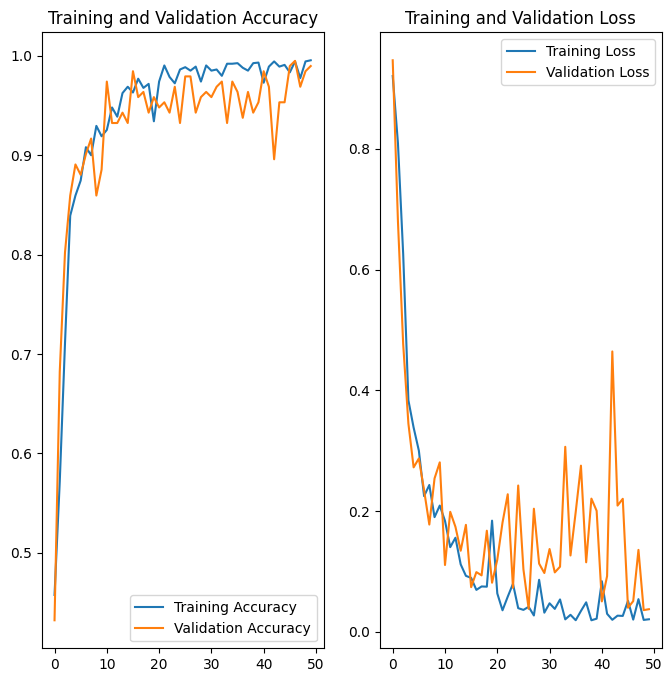

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Predicted label :  Potato___Early_blight


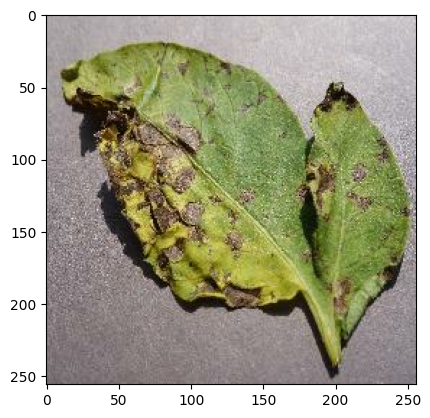

In [51]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img,):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


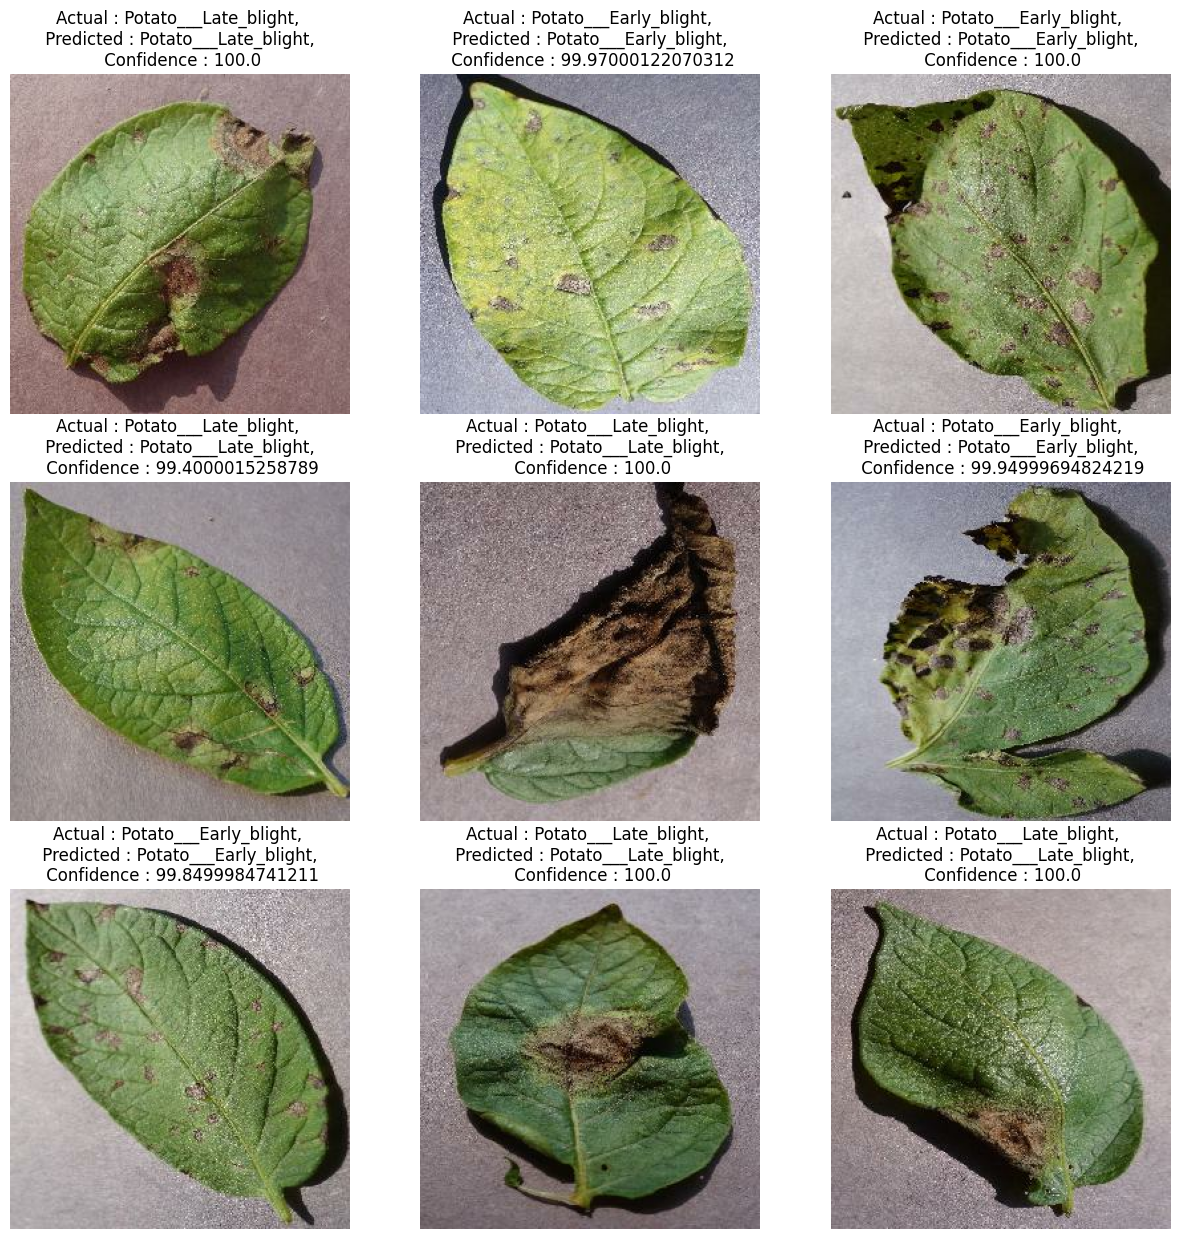

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence : {confidence}")
        
        plt.axis("off")

In [67]:
model_version = 2
save_path = f"models/{model_version}"
model.export(save_path)

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


Saved artifact at 'models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1524708962576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524708961424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671549648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671546576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671548496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671551184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671551568: TensorSpec(shape=(), dty

In [71]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]])+1
model.export(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/5\assets


INFO:tensorflow:Assets written to: models/5\assets


Saved artifact at 'models/5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1524708962576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524708961424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671549648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671546576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671548496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671551184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671550992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1524671551568: TensorSpec(shape=(), dty

In [1]:
pip install fastapi

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install uvicorn

Note: you may need to restart the kernel to use updated packages.
